<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/boston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install gpytorch

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp -r "drive/My Drive/NIPS2020/auxfunc/" .
!cp -r "drive/My Drive/NIPS2020/datasets/" .
!cp -r "drive/My Drive/NIPS2020/style/" .
!cp -r "drive/My Drive/NIPS2020/runs/" .

In [ ]:
%load_ext tensorboard

In [ ]:
#%%
# Imports
import io #Used as buffer
import sys
import matplotlib
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.sigfunc as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn.datasets import load_boston
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, decomposition,\
     tree, neighbors, discriminant_analysis, gaussian_process, preprocessing
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#%%
# MODELS
# ====================
# Grid search for parameters and classifiers

models = { 
        'predictor':
            [
            svm.SVC(),
            gaussian_process.GaussianProcessClassifier(),
            linear_model.LinearRegression(),
            linear_model.Lasso(),
            svm.SVR()],
        'name':
            [
            'SVM',
            'GPClassifier',
            'LinReg',
            'Lasso',
            'SVR']}
parameters = [
            {'SVM__kernel':['poly'],'SVM__degree':[3,4,5]},
            {'GPClassifier__kernel':[]},
            {},
            {'Lasso__alpha':np.linspace(0.01,1,10)},
            {'SVR__kernel':['linear'], 'SVR__C':np.logspace(-1, 1, 10), 'SVR__epsilon':np.logspace(-2, 2, 10)} ]


In [ ]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False))
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [ ]:
#%%
# Initialize model
def init_model(input_dim, models, parameters, clf_name):
    i = np.nonzero(np.array(models['name'])==clf_name)[0].squeeze()
      
    scaler = preprocessing.StandardScaler()
    steps = [('scaler', scaler), (models['name'][i], models['predictor'][i])]
    ppline = pipeline.Pipeline(steps) # define the pipeline object.

    clf = model_selection.GridSearchCV(ppline, param_grid=parameters[i], cv=5, iid=False)
    return clf

In [ ]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    if hasattr(model, "decision_function"):
      y_pred_soft = model.best_estimator_.decision_function(X)[:,None]
    elif hasattr(model, "predict_proba"):
      y_pred_soft = model.best_estimator_.predict_proba(X)
    else:
      y_pred_soft = model.best_estimator_.predict(X)[:,None]
    y_pred_th = model.best_estimator_.predict(X) 
    return y_pred_soft, y_pred_th

In [ ]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [ ]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf):
      if clf=='svm':
          direction = 'closer'
          crit_val = np.abs(y_val_pred_soft.ravel())
          crit_test = np.abs(y_test_pred_soft.ravel())
      else:
          direction = 'further'
          p_val = np.concatenate((y_val_pred_soft,1-y_val_pred_soft),axis=1)
          crit_val = entropy(p_val, axis=1, base=2)
          p_test = np.concatenate((y_test_pred_soft,1-y_test_pred_soft),axis=1)
          crit_test = entropy(p_test, axis=1, base=2)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val)
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [ ]:
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data
# -------------
boston = load_boston()
Data_X = boston.data
Data_y = boston.target

In [ ]:
# For reproducibility
# tf.random.set_seed(54321)
np.random.seed(12345)
torch.manual_seed(0)
#%%
# Assign labels
report_table = []
report_criteria = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
clf = 'SVR'
addPredictions = True
applyPCA = True
accuracy = 0
for sample, test in kf.split(Data_X):
    X = Data_X[sample]
    y = Data_y[sample]
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=123)
    X_test = Data_X[test]
    y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=X.shape[1], models=models, parameters=parameters, clf_name=clf)
    model.fit(X_train, y_train)

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train)
    # print('accuracy(Train)={}'.format(np.sum(y_train==y_train_pred_th)/np.size(y_train)))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val)
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test)

    X_train_GP = X_train
    X_val_GP = X_val
    X_test_GP = X_test
    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train, y_train_pred_soft), axis=1)
            X_val_GP = np.concatenate((X_val, y_val_pred_soft), axis=1)
            X_test_GP = np.concatenate((X_test, y_test_pred_soft), axis=1)
    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)
    if applyPCA:
            pca_GP = decomposition.PCA(.99).fit(np.concatenate((X_train_GP, X_val_GP), axis=0)) # set percentage of energy preserved by PCA
            # Apply PCA transform to all sets
            X_train_GP = pca_GP.transform(X_train_GP)
            X_val_GP = pca_GP.transform(X_val_GP)
            X_test_GP = pca_GP.transform(X_test_GP)
    
    table, exp = signalingFunction(X_train_GP, y_train, y_train_pred_th, X_val_GP,\
                                   y_val, y_val_pred_th, X_test_GP, y_test, y_test_pred_th,\
                                   kernel='RBF', norm='labs')
    report_table.append(table)
    
    # # Baseline for comparison
    # crit_table = baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf)
    # report_criteria.append(crit_table)

    # if accuracy < model.best_estimator_.score(X_val,y_val):
    #     accuracy = model.best_estimator_.score(X_val,y_val)
    #     classifier = model.best_estimator_
    #     X_test_surface_plot = X_test
    #     y_test_surface_plot = y_test
    #     X_train_surface_plot = X_train
    #     y_train_surface_plot = y_train
    #     X_val_surface_plot = X_val
    #     y_val_surface_plot = y_val
    #     scaler_surface_plot = scaleX_GP
    #     exp_surface_plot = exp
    #     table_surface_plot = table

    del(model)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 2.826  noise: 2.387
Iter 492/500 - Loss: 2.825  noise: 2.389
Iter 493/500 - Loss: 2.824  noise: 2.391
Iter 494/500 - Loss: 2.823  noise: 2.394
Iter 495/500 - Loss: 2.822  noise: 2.396
Iter 496/500 - Loss: 2.821  noise: 2.398
Iter 497/500 - Loss: 2.820  noise: 2.400
Iter 498/500 - Loss: 2.819  noise: 2.402
Iter 499/500 - Loss: 2.818  noise: 2.404
Iter 500/500 - Loss: 2.817  noise: 2.406
evaluating with cuda...
evaluating with cuda...


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 2.978  noise: 2.366
Iter 492/500 - Loss: 2.976  noise: 2.368
Iter 493/500 - Loss: 2.975  noise: 2.371
Iter 494/500 - Loss: 2.974  noise: 2.373
Iter 495/500 - Loss: 2.973  noise: 2.375
Iter 496/500 - Loss: 2.972  noise: 2.377
Iter 497/500 - Loss: 2.970  noise: 2.379
Iter 498/500 - Loss: 2.969  noise: 2.381
Iter 499/500 - Loss: 2.968  noise: 2.383
Iter 500/500 - Loss: 2.967  noise: 2.385
evaluating with cuda...
evaluating with cuda...


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 2.689  noise: 2.381
Iter 492/500 - Loss: 2.688  noise: 2.383
Iter 493/500 - Loss: 2.687  noise: 2.385
Iter 494/500 - Loss: 2.686  noise: 2.387
Iter 495/500 - Loss: 2.685  noise: 2.390
Iter 496/500 - Loss: 2.684  noise: 2.392
Iter 497/500 - Loss: 2.684  noise: 2.394
Iter 498/500 - Loss: 2.683  noise: 2.396
Iter 499/500 - Loss: 2.682  noise: 2.398
Iter 500/500 - Loss: 2.681  noise: 2.400
evaluating with cuda...
evaluating with cuda...


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 2.927  noise: 2.447
Iter 492/500 - Loss: 2.926  noise: 2.450
Iter 493/500 - Loss: 2.925  noise: 2.452
Iter 494/500 - Loss: 2.924  noise: 2.454
Iter 495/500 - Loss: 2.923  noise: 2.457
Iter 496/500 - Loss: 2.921  noise: 2.459
Iter 497/500 - Loss: 2.920  noise: 2.461
Iter 498/500 - Loss: 2.919  noise: 2.464
Iter 499/500 - Loss: 2.918  noise: 2.466
Iter 500/500 - Loss: 2.917  noise: 2.468
evaluating with cuda...
evaluating with cuda...


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 2.801  noise: 2.318
Iter 492/500 - Loss: 2.800  noise: 2.320
Iter 493/500 - Loss: 2.799  noise: 2.322
Iter 494/500 - Loss: 2.798  noise: 2.324
Iter 495/500 - Loss: 2.797  noise: 2.326
Iter 496/500 - Loss: 2.796  noise: 2.328
Iter 497/500 - Loss: 2.795  noise: 2.330
Iter 498/500 - Loss: 2.793  noise: 2.332
Iter 499/500 - Loss: 2.792  noise: 2.334
Iter 500/500 - Loss: 2.791  noise: 2.336
evaluating with cuda...
evaluating with cuda...


In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [ ]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
# report_criteria_concat = pd.concat(report_criteria)
# columns_crit = ['rho_user','%reduction_test']
# df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
# df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
# columns_jac = ['rho_user','jaccard']
# df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Unfiltered Result dataframes
cols_fx = ['rho_user','%reduction_val','budget','%reduction_test']
results_fx = pd.DataFrame(report_table_concat[cols_fx])
# cols_fxgx = ['rho_user','%reduction_test', 'jaccard']
# results_fxgx = pd.concat([df_boxplot_table[cols_fxgx[:2]], df_boxplot_crit[cols_fxgx[1]], df_jaccard[cols_fxgx[2]]], axis=1)
# Filter experiments with p_value > 0.05
# df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
# df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table]
df = pd.concat(frames)

In [ ]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.05:
      df.loc[df.index==i,'%reduction_test'] = np.nan
      # df_jaccard.loc[df_jaccard.index==i, 'jaccard'] = np.nan

In [ ]:
# Dataframe for results f(x)
results_fx_by_row_index = results_fx.groupby(results_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output_fx = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
output_fx.write("results_fx (\\rho|%reduction_val|sig_rate|%reduction_test|H0)\n")
output_fx.write("----------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output_fx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fx.getvalue())

results_fx (\rho|%reduction_val|sig_rate|%reduction_test|H0)
----------
{} & {} & 0.05 & 18.8(9.7-20.7) & 0.05(0.04-0.05) & 8.1(7.8-15.9) & $\surd$ \\
{} & {} & 0.10 & 26.4(20.3-31.9) & 0.08(0.07-0.09) & 19.3(14.8-20.3) & $\surd$ \\
{} & {} & 0.15 & 40.3(26.4-42.7) & 0.12(0.11-0.12) & 34.2(24.8-36.2) & $\surd$ \\
{} & {} & 0.20 & 47.2(33.6-51.6) & 0.16(0.15-0.16) & 41.9(30.0-43.1) & $\surd$ \\



In [ ]:
# Dataframe for comparison f(x)-g(x)
# results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
# fxgx_median = results_fxgx_by_row_index.median()
# fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
# fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# # Baseline comparison statistics (median(q1-q3)) LaTex
# output_fxgx = io.StringIO()
# numRows = fxgx_median.shape[0]
# numCols = fxgx_median.shape[1]
# output_fxgx.write("results_fxgx (\\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0\n")
# output_fxgx.write("------------\n")
# for i in range(numRows):
#   row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
#          else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==3)\
#          else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
#   output_fxgx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
# print(output_fxgx.getvalue())

In [ ]:
#%%
# Save results in csv fomat
path_csv = "drive/My Drive/NIPS2020/results/boston/results_{clf}_yhat{yhat}_pca{pca}.csv".format(clf=clf, pca=applyPCA, yhat=addPredictions)
results = pd.concat([results_fx], keys=['fx'], axis=1).to_csv(path_csv, index=True, header=True)
# Save results in tex fomat
L = [output_fx.getvalue()]
path_txt = "drive/My Drive/NIPS2020/results/boston/results_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(L) 
txt.close() #to change file access modes 

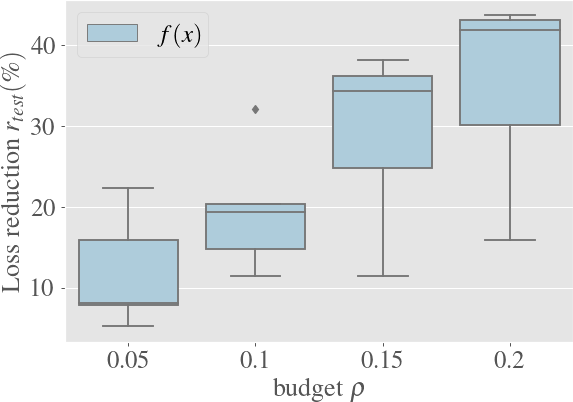

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax, palette=pal)
ax.set_xlabel(r'budget $\rho$')
ax.set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax.legend(loc='upper left')
# pal = sns.color_palette('BuGn_r')
# sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
# ax[1].set_xlabel(r'budget $\rho$')
# ax[1].set_ylabel(r'Jaccard index $J$')
plt.tight_layout()
path_fig_fx = "drive/My Drive/NIPS2020/results/boston/fig_fxgx_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fx, bbox_inches='tight', facecolor='w')